In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/AI_weather')

In [ ]:
weather = pd.read_csv("train.csv")
weather.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
0,0,6.8,0.24,0.29,9.5,0.042,56.0,157.0,0.99586,3.11,0.51,10.1,3
1,1,6.2,0.37,0.24,6.1,0.032,19.0,86.0,0.98934,3.04,0.26,13.4,5
2,2,6.0,0.40,0.30,1.6,0.047,30.0,117.0,0.99310,3.17,0.48,10.1,3
3,3,7.1,0.28,0.19,7.8,0.040,48.0,184.0,0.99579,3.16,0.50,9.4,2
4,4,7.0,0.35,0.24,1.9,0.040,21.0,144.0,0.99230,3.35,0.38,11.0,2


### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [ ]:
answer_Y=weather.Y
drop_list = ['Unnamed: 0']
cleaned_df = weather.drop(drop_list,axis = 1 )
cleaned_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
0,6.8,0.24,0.29,9.5,0.042,56.0,157.0,0.99586,3.11,0.51,10.1,3
1,6.2,0.37,0.24,6.1,0.032,19.0,86.0,0.98934,3.04,0.26,13.4,5
2,6.0,0.40,0.30,1.6,0.047,30.0,117.0,0.99310,3.17,0.48,10.1,3
3,7.1,0.28,0.19,7.8,0.040,48.0,184.0,0.99579,3.16,0.50,9.4,2
4,7.0,0.35,0.24,1.9,0.040,21.0,144.0,0.99230,3.35,0.38,11.0,2


Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


3    1651
2    1096
4     652
5     135
1     120
Name: Y, dtype: int64


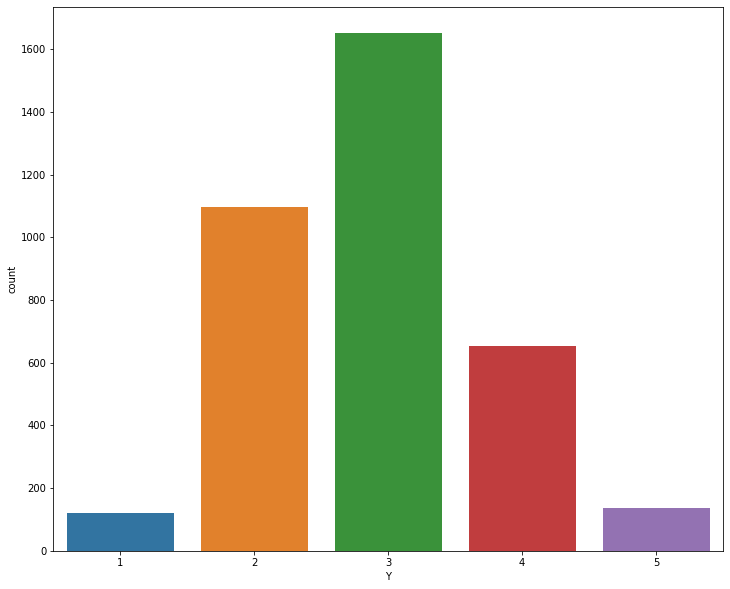

In [ ]:
ax = sns.countplot(answer_Y,label="Count")
print(answer_Y.value_counts())
l1, l2, l3, l4, l5 = answer_Y.value_counts()

Balance the Data

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=500)
X_smote, Y_smote = smote.fit_sample(cleaned_df,answer_Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
X_smote

array([[ 6.8       ,  0.24      ,  0.29      , ...,  0.51      ,
        10.1       ,  3.        ],
       [ 6.2       ,  0.37      ,  0.24      , ...,  0.26      ,
        13.4       ,  5.        ],
       [ 6.        ,  0.4       ,  0.3       , ...,  0.48      ,
        10.1       ,  3.        ],
       ...,
       [ 6.7931489 ,  0.27506808,  0.31931489, ...,  0.6831489 ,
        12.26438297,  5.        ],
       [ 6.77429367,  0.22937286,  0.34365725, ...,  0.52782677,
        11.71943494,  5.        ],
       [ 6.82674825,  0.22      ,  0.30331294, ...,  0.38331294,
        11.98024474,  5.        ]])

In [ ]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Y'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Y'))
test_labels = np.array(test_df.pop('Y'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

val_features
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

train_labels = pd.get_dummies(train_labels,sparse=True)
test_labels = pd.get_dummies(test_labels,sparse=True)
val_labels = pd.get_dummies(val_labels,sparse=True)
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


array([[-0.39840513, -0.47069173, -0.6917253 , ..., -0.26983827,
        -0.58859532, -1.09203845],
       [-1.47746818, -1.53944641, -0.60848613, ...,  1.1152657 ,
        -0.23861163, -1.09203845],
       [-0.39840513, -0.17921318,  3.3869938 , ..., -0.07196628,
         0.46135574, -0.85089533],
       ...,
       [ 1.16024149,  0.11226537,  0.22390552, ...,  0.45569238,
        -1.02607492,  0.51558238],
       [-0.39840513,  0.01510585, -0.02581197, ...,  0.19186305,
         0.19886797, -0.69013324],
       [-0.63819692, -0.47069173, -0.27552947, ...,  0.58760704,
        -0.76358716,  0.99786864]])

In [ ]:
train_labels

,1,2,3,4,5
0,0,1,0,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
2333,0,0,1,0,0
2334,0,0,1,0,0
2335,0,0,1,0,0
2336,1,0,0,0,0


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the distributions?
    * Yes the positive examples contain a much higher rate of extreme values.

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = Sequential()
  model.add(Dense(256, activation='relu',input_dim=11)) 
  for i in range(5):
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax',bias_initializer=output_bias))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

  return model

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [ ]:
EPOCHS = 150
BATCH_SIZE = 10

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_360 (Dense)            (None, 256)               3072      
_________________________________________________________________
dense_361 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_240 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_362 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_241 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_363 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_242 (Dropout)        (None, 128)             

Test run the model:

In [ ]:
model.predict(train_features[:10])

array([[0.09841722, 0.27535298, 0.22441506, 0.1586069 , 0.24320789],
       [0.09047152, 0.27003133, 0.22927138, 0.17632222, 0.23390345],
       [0.10096019, 0.2888353 , 0.22647311, 0.14524929, 0.23848213],
       [0.11133619, 0.27283776, 0.22468144, 0.15198538, 0.23915924],
       [0.10397301, 0.27394155, 0.2231561 , 0.16304277, 0.23588654],
       [0.10896584, 0.26918647, 0.22825865, 0.1538913 , 0.23969778],
       [0.10742947, 0.27572557, 0.23085526, 0.14863572, 0.23735404],
       [0.109071  , 0.2631505 , 0.23708364, 0.15034708, 0.24034776],
       [0.10586432, 0.27953148, 0.237452  , 0.14973348, 0.22741878],
       [0.10579574, 0.26528773, 0.2304252 , 0.15700221, 0.24148917]],
      dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.5061


In [ ]:
model = make_model(output_bias=None)
model.predict(train_features[:10])

array([[0.1191036 , 0.34429178, 0.07502451, 0.1428804 , 0.31869972],
       [0.12415014, 0.34093225, 0.07640043, 0.1363984 , 0.32211876],
       [0.10867872, 0.34481668, 0.07750338, 0.13979307, 0.32920805],
       [0.10709494, 0.34824434, 0.08089738, 0.13597214, 0.32779115],
       [0.11542398, 0.3531    , 0.07781123, 0.13685587, 0.31680894],
       [0.11214091, 0.3460452 , 0.07852865, 0.13658549, 0.32669973],
       [0.10645702, 0.35744396, 0.08037866, 0.13255152, 0.32316878],
       [0.12044375, 0.33335292, 0.07723605, 0.12957709, 0.33939025],
       [0.11170427, 0.33543462, 0.08219475, 0.13819209, 0.33247426],
       [0.10702825, 0.3449577 , 0.08138718, 0.13757068, 0.3290562 ]],
      dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.9272


This initial loss is about 50 times less than if would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

### Train the model

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/150
234/234 [==============================] - 2s 10ms/step - loss: 1.4282 - tp: 517.0000 - fp: 517.0000 - tn: 11175.0000 - fn: 2406.0000 - accuracy: 0.8000 - precision: 0.5000 - recall: 0.1769 - auc: 0.7599 - val_loss: 1.3472 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2340.0000 - val_fn: 585.0000 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7595
Epoch 2/150
234/234 [==============================] - 1s 5ms/step - loss: 1.2925 - tp: 354.0000 - fp: 394.0000 - tn: 8958.0000 - fn: 1984.0000 - accuracy: 0.7966 - precision: 0.4733 - recall: 0.1514 - auc: 0.7806 - val_loss: 1.2589 - val_tp: 26.0000 - val_fp: 16.0000 - val_tn: 2324.0000 - val_fn: 559.0000 - val_accuracy: 0.8034 - val_precision: 0.6190 - val_recall: 0.0444 - val_auc: 0.7967
Epoch 3/150
234/234 [==============================] - 1s 4ms/step - loss: 1.2391 - tp: 417.0000 - fp: 455.0000 - tn: 8897.0000 - fn: 1921.0000 - accuracy: 0.7967 - precision: 0.4782 - recall: 0.1

Output

In [ ]:
# Use a utility from sklearn to split and shuffle our dataset.
all_train_df = weather.drop(drop_list,axis = 1 )
all_train_df.head()
# Form np arrays of labels and features.
all_train_labels = np.array(all_train_df.pop('Y'))
all_bool_train_labels = all_train_labels != 0

all_train_features = np.array(all_train_df)

In [ ]:
scaler = StandardScaler()
all_train_features = scaler.fit_transform(all_train_features)

all_train_features = np.clip(all_train_features, -5, 5)

all_train_labels = pd.get_dummies(all_train_labels,sparse=True)

print('Training labels shape:', train_labels.shape)
print('Training features shape:', train_features.shape)

Training labels shape: (2338, 5)
Training features shape: (2338, 11)


In [ ]:
all_train_labels

,1,2,3,4,5
0,0,0,1,0,0
1,0,0,0,0,1
2,0,0,1,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
3649,0,1,0,0,0
3650,0,1,0,0,0
3651,0,0,1,0,0
3652,0,1,0,0,0


In [ ]:
model.fit(
    all_train_features,
    all_train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/150
366/366 [==============================] - 2s 5ms/step - loss: 0.6844 - tp: 2621.0000 - fp: 818.0000 - tn: 13798.0000 - fn: 1033.0000 - accuracy: 0.8987 - precision: 0.7621 - recall: 0.7173 - auc: 0.9391 - val_loss: 0.5388 - val_tp: 465.0000 - val_fp: 83.0000 - val_tn: 2257.0000 - val_fn: 120.0000 - val_accuracy: 0.9306 - val_precision: 0.8485 - val_recall: 0.7949 - val_auc: 0.9658
Epoch 2/150
366/366 [==============================] - 2s 6ms/step - loss: 0.6459 - tp: 2674.0000 - fp: 793.0000 - tn: 13823.0000 - fn: 980.0000 - accuracy: 0.9030 - precision: 0.7713 - recall: 0.7318 - auc: 0.9451 - val_loss: 0.5469 - val_tp: 462.0000 - val_fp: 88.0000 - val_tn: 2252.0000 - val_fn: 123.0000 - val_accuracy: 0.9279 - val_precision: 0.8400 - val_recall: 0.7897 - val_auc: 0.9637
Epoch 3/150
366/366 [==============================] - 2s 5ms/step - loss: 0.6836 - tp: 2715.0000 - fp: 762.0000 - tn: 13854.0000 - fn: 939.0000 - accuracy: 0.9069 - precision: 0.7808 - recall: 0.7430 - auc:

In [ ]:
test_data = pd.read_csv("test.csv")
test_data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,0,6.0,0.19,0.26,12.4,0.048,50.0,147.0,0.99720,3.30,0.36,8.9
1,1,6.4,0.22,0.38,9.1,0.044,35.0,127.0,0.99326,2.97,0.30,11.0
2,2,8.1,0.30,0.49,12.3,0.049,50.0,144.0,0.99710,3.09,0.57,10.2
3,3,6.6,0.19,0.35,1.5,0.037,37.0,107.0,0.99006,3.18,0.68,12.0
4,4,6.6,0.28,0.30,12.9,0.033,31.0,177.0,0.99479,3.12,0.39,11.2


In [ ]:
drop_list2 = ['Unnamed: 0']
test_data_X = test_data.drop(drop_list2,axis = 1 )
test_data_X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,6.0,0.19,0.26,12.4,0.048,50.0,147.0,0.99720,3.30,0.36,8.9
1,6.4,0.22,0.38,9.1,0.044,35.0,127.0,0.99326,2.97,0.30,11.0
2,8.1,0.30,0.49,12.3,0.049,50.0,144.0,0.99710,3.09,0.57,10.2
3,6.6,0.19,0.35,1.5,0.037,37.0,107.0,0.99006,3.18,0.68,12.0
4,6.6,0.28,0.30,12.9,0.033,31.0,177.0,0.99479,3.12,0.39,11.2


In [ ]:
test_train_features = np.array(test_data_X)

In [ ]:
test_train_features

array([[ 6.  ,  0.19,  0.26, ...,  3.3 ,  0.36,  8.9 ],
       [ 6.4 ,  0.22,  0.38, ...,  2.97,  0.3 , 11.  ],
       [ 8.1 ,  0.3 ,  0.49, ...,  3.09,  0.57, 10.2 ],
       ...,
       [ 7.3 ,  0.29,  0.37, ...,  3.12,  0.47,  9.  ],
       [ 7.6 ,  0.22,  0.34, ...,  3.08,  0.49,  9.8 ],
       [ 6.8 ,  0.21,  0.36, ...,  3.27,  0.48,  8.8 ]])

In [ ]:
scaler = StandardScaler()
# test_train_features = scaler.fit_transform(test_train_features)

test_train_features = np.clip(test_train_features, -5, 5)

print('Training features shape:', train_features.shape)

Training features shape: (2338, 11)


In [ ]:
test_train_features

array([[5.  , 0.19, 0.26, ..., 3.3 , 0.36, 5.  ],
       [5.  , 0.22, 0.38, ..., 2.97, 0.3 , 5.  ],
       [5.  , 0.3 , 0.49, ..., 3.09, 0.57, 5.  ],
       ...,
       [5.  , 0.29, 0.37, ..., 3.12, 0.47, 5.  ],
       [5.  , 0.22, 0.34, ..., 3.08, 0.49, 5.  ],
       [5.  , 0.21, 0.36, ..., 3.27, 0.48, 5.  ]])

In [ ]:
Y_predict = model.predict_classes(test_train_features)

In [ ]:
Y_predict

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
Y_predict+=1

In [ ]:
Y_predict

array([3, 3, 3, ..., 3, 3, 3])

In [ ]:
predict_sample = pd.read_csv("sample_submission.csv", index_col=0)
predict_sample['Y'] = Y_predict
predict_sample.to_csv("predict_6.csv")